# Определение возраста человека по фото

Необходимо построить модель для сетевого супермаркета, которая определяет приблизитльный возраст человека по фото. Модель будет использоваться магазином для того, чтобы
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
- контролировать добросовестность кассиров при продаже алкоголя

Целевая метрика проекта - MAE. Необходимо достичь значения не более 8 на тестовой выборке для успешной сдачи проекта

В нашем распоряжении папка со всеми изображениями и CSV-файл с двумя столбцами:
- `file_name` - название файла с изображением
- `real_age` - реальный возраст человека на фото, целевой признак

## Исследовательский анализ данных

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Загрузим файл с маркировками
try:
    marked_data = pd.read_csv('/datasets/faces/labels.csv')
except:
    marked_data = pd.read_csv(
        'https://code.s3.yandex.net/datasets/faces/labels.csv')

Выведем первые строчки датасета для лучшего понимания его структуры

In [3]:
marked_data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В столбце `file_name` находятся названия файлов фотографий, а в столбце `real-age` - возраст человека на фото. Выведем информацию о датасете

In [4]:
marked_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков в датасете нет и типы данных приведены правильно. Так как главной задачей проекта является построение модели, определяющей возраст по фото (непрерывная величина), перед нами стоит задача регрессии. Для обучения модели нам доступно 7591 фотографий, что может оказаться недостаточным количеством для качественного построения модели. Рассуждая более точно, нам требуется около 15000 изображений, если апроксимировать задачу регрессии классификацией на 15 классов (1000 на один класс), что будет давать примерно такую же точность. Следовательно, для качественного обучения модели требуется примерно в 2 раза больше данных. Данную проблему можно исправить с помощью аугментации изображений. Следовательно, данных для построения модели должно хватить.
  
Исследуем информацию о возрасте людей из выборки

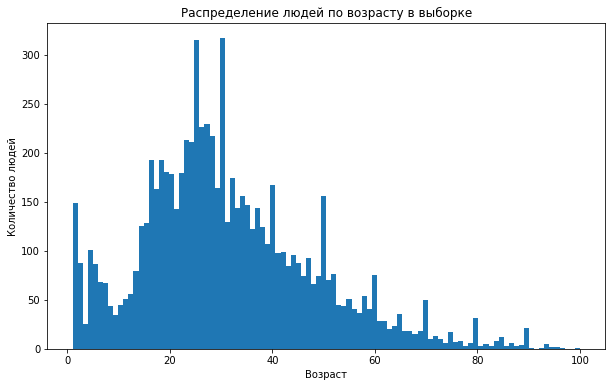

,Статистические свойства распределения возраста людей из выборки
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
# Построим график распределения людей из выборки по возрасту
marked_data['real_age'].plot(kind='hist', figsize=(10, 6), bins=100)
plt.ylabel('Количество людей')
plt.xlabel('Возраст')
plt.title('Распределение людей по возрасту в выборке')
plt.show()

# Выведем описание датасета 
description = pd.DataFrame(marked_data['real_age'].describe())
description.columns = ['Статистические свойства распределения возраста ' 
                       'людей из выборки']
display(description)

В выборке присутствуют 7591 фотографии с людьми. Средний возраст - 31 год, медианный - 29 лет, что позволяет сделать вывод о смещенности ряда вправо. Это также видно на гистограмме. Основываясь на минимальное и максимальное значения возраста, можно сделать вывод о том, что в выборке скорее всего присутствуют выбросы

In [6]:
# Загрузим папку с фотографиями
datagen = ImageDataGenerator(rescale=1/255.)

train_datagen = datagen.flow_from_dataframe(
            dataframe=marked_data,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            class_mode='raw',
            target_size=(224, 224),
            batch_size=32,
            seed=12345
)

features, target = next(train_datagen)

Found 7591 validated image filenames.


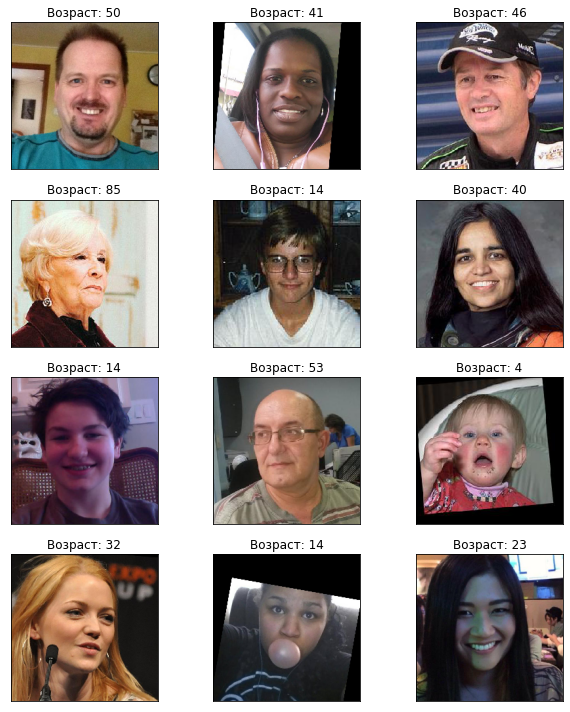

In [7]:
fig = plt.figure(figsize=(10, 10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В данном разделе проекта мы загрузили датасет с фотографиями людей и его разметкой по возрасту (целевой признак).  
  
Также, нами был проведен исследовательский анализ данных. В выборке присутствуют фотографии людей разных возрастов (детей, подростков, взрослых, пожилых). Распределение возраста смещено вправо с медианным значением - 29 лет, и средним - примерно 31 год. Также можно отметить, фотографии сделаны с разных ракурсов и углов. Это позволит модели обучиться лучше

## Построение модели

Так как модель обучалась на стороннем сервере, в данной части проекта код представлен в текстовой ячейке markdown

```python
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2, horizontal_flip=True)
    marked_data = pd.read_csv(path + 'labels.csv')
    train_datagen = datagen.flow_from_dataframe(
			dataframe=marked_data,
			directory=path + 'final_files/',
			x_col='file_name',
			y_col='real_age',
			class_mode='raw',
			target_size=(244, 244),
			batch_size=32,
			subset='training',
			seed=12345)
    return train_datagen

def load_test(path):
    marked_data = pd.read_csv(path  + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
    test_datagen = datagen.flow_from_dataframe(
			dataframe=marked_data,
			directory=path + 'final_files/',
			x_col='file_name',
			y_col='real_age',
			class_mode='raw',
			target_size=(244, 244),
			batch_size=32,
			subset='validation',
			seed=12345)
    return test_datagen

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
		include_top=False, 
		weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 
```

**Результат обучения модели:**

```python
Train for 190 steps, validate for 48 steps
Epoch 1/10
190/190 - 71s - loss: 223.5141 - mae: 10.6945 - val_loss: 478.4330 - val_mae: 16.6655
Epoch 2/10
190/190 - 50s - loss: 77.6990 - mae: 6.6737 - val_loss: 399.3102 - val_mae: 14.8330
Epoch 3/10
190/190 - 46s - loss: 50.3635 - mae: 5.4317 - val_loss: 302.9311 - val_mae: 12.7257
Epoch 4/10
190/190 - 48s - loss: 36.3526 - mae: 4.5930 - val_loss: 104.9137 - val_mae: 7.5396
Epoch 5/10
190/190 - 41s - loss: 27.8952 - mae: 4.0183 - val_loss: 77.7577 - val_mae: 6.5268
Epoch 6/10
190/190 - 39s - loss: 22.4410 - mae: 3.6560 - val_loss: 69.6509 - val_mae: 6.3622
Epoch 7/10
190/190 - 49s - loss: 19.3675 - mae: 3.3840 - val_loss: 81.7822 - val_mae: 7.0910
Epoch 8/10
190/190 - 60s - loss: 16.4128 - mae: 3.1288 - val_loss: 62.0822 - val_mae: 5.8232
Epoch 9/10
190/190 - 58s - loss: 13.9846 - mae: 2.8550 - val_loss: 64.9821 - val_mae: 6.0968
Epoch 10/10
190/190 - 57s - loss: 11.3779 - mae: 2.5964 - val_loss: 59.9061 - val_mae: 5.7756
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 9s - loss: 59.9061 - mae: 5.7756
Test MAE: 5.7756
```

Результат MAE на тестовой выборке - примерно 5.77. Следовательно, пороговое значение мерки качества модели удовлетворяет требованиям заказчика. Однако, необходимо обратить внимание на то, что модель склонна к переобучению, так как значение MAE на валидационной выборке гораздо выше, чем на обучающей

## Вывод

Подводя итоги, целью данного проекта было построение модели, определяющей примерный возраст человека по фото. Проверять качество модели необходимо с помощью метрики качества MAE. Для успешной сдачи проекта MAE на тестовой выборке должен быть не более 8.   
  
На первом этапе мы открыли файл с разметкой фотографий и загрузили папку с самими изображениями. Изучив выборку, мы заметили наличие выбросов со значением 1 год, что необходимо уточнить у специалистов, ответственных за выгрузку данных. Средний возраст людей на фото - 31 год, а медианный - 29 лет, что свидетельствует о том, что распределение смещено вправо. Так как в выборке присутствуют изображения людей разных возрастных категорий и фото сделаны в разных ракурсах, данных для обучения модели достаточно.  
  
На следующем этапе проекта мы обучили нейронную сеть архитектуры ResNet50, предобученные веса модели были загружены с сервера, заморозка весов бэкбона не была использована. Был выбран размер батча - 32 фотографии, модель обучалась на 10 эпохах. В качестве оптимизатора для обучения модели был выбран алгоритм Adam с шагом 0.00001. Результат MAE на обучающей выборке около 2.59, что гораздо ниже, чем на тестовой - около 5.77. Модель прошла пороговое значение метрики MAE, однако стоить отметить, что модель склонна к переобучению. 